In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Creazione dei dati

In [2]:
# Numero casuale
rnd = np.random
rnd.seed(0)

In [3]:
n = 10    # Numero punti vendita
# Bisogna ricordare che il nodo deposito, nella nostra formulazione, corrisponde a D={'s', 't'}
  # con 's' visto come nodo deposito per l'uscita dei veicoli e 'v' come nodo deposito per entrata
# Di conseguenza, poniamo 's'=xc[0] e 't'=xc[n+1]
xc = rnd.rand(n+1)*200      # Vettore di coordinate x dei vari nodi
xc = np.append(xc, xc[0])   # Coordinate x di 't' devono essere uguali alle coordinate x di 's'
yc = rnd.rand(n+1)*100      # Vettore di coordinate y dei vari nodi
yc = np.append(yc, yc[0])   # Coordinate y di 't' devono essere uguali alle coordinate y di 's'

In [4]:
# CREAZIONE DATI

P = [il for il in range(1,n+1)]         # Insieme P dei punti vendita
N = [0] + P + [n+1]                     # Insieme N dei nodi, come unione di P e D={'s','t'}
                                          # 's' corrisponde al nodo 0, mentre 't' corrisponde al nodo n+1

# Insieme A degli archi
# Devo controllare che il nodo i sia differente da j. Inoltre, devo anche controllare di non includere
  # gli archi ('s','t') e ('t','s') poichè sia 's' che 't' corrispondono al nodo deposito
A = [(i,j) for i in N for j in N if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1)]

# Costi associati a ogni arco
c = {(i,j): np.random.randint(2,15) for i,j in A}

# Tempo di percorrenza degli archi
# Per semplicità ho posto il tempo di percorrenza come la distanza tra i nodi i e j
t = {(i,j): int(np.hypot(xc[i]-xc[j], yc[i]-yc[j])) for i,j in A}

# Richiesta per ogni nodo
np.random.seed(0)
d = {i: np.random.randint(10,15) for i in P}
d[0] = 0                                    # Nodo deposito 's'
d[n+1] = 0                                  # Nodo deposito 't'

# Finestre di apertura dei punti di vendita
a = {0:0, 1:10, 2:10, 3:10, 4:20, 5:20, 6:20, 7:40, 8:40, 9:40, 10:40, 11:0}      # Orario di apertura
b = {0:100, 1:140, 2:140, 3:140, 4:140, 5:150, 6:150, 7:180, 8:180, 9:180, 10:180, 11:200} # Orario di chiusura


V = [1,2,3,4]                               # Insieme V dei veicoli
Q = {1: 50, 2:50, 3:25, 4:25}               # Insieme Q delle capacità massime dei veicoli

# Tempo di servizio
s = {(i,k): np.random.randint(3,5) if i!=0 and i!=n+1 else 0 for i in N for k in V}

In [5]:
print(P)
print(N)
print(xc)
print(yc)
print(A)
print(c)
print(f"t;{t}")
print(d)
print(a)
print(b)
print(s)
print(V)
print(Q)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[109.76270079 143.03787327 120.55267521 108.9766366   84.73095987
 129.17882261  87.51744225 178.35460016 192.7325521   76.68830377
 158.34500762 109.76270079]
[52.88949198 56.80445611 92.55966383  7.10360582  8.71292997  2.02183974
 83.26198455 77.81567509 87.00121482 97.86183422 79.91585642 52.88949198]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), 

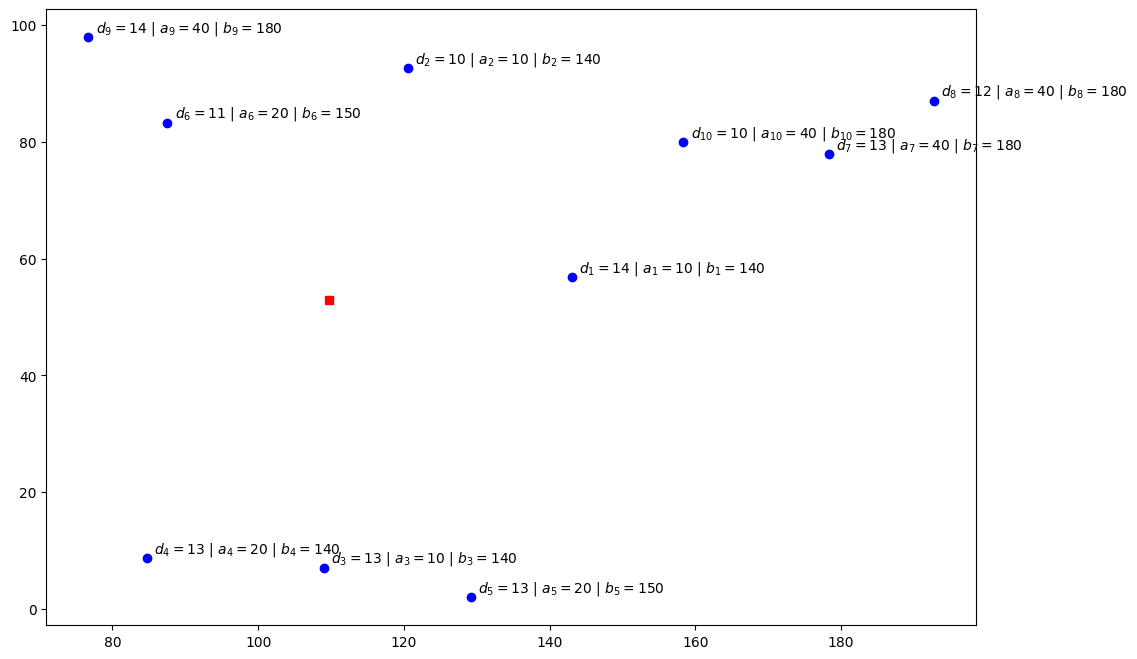

In [6]:
# Visualizzazione deposito e punti vendita
plt.figure(figsize=(12,8))
plt.plot(xc[0], yc[0], c='r', marker='s')     # Nodo deposito
plt.scatter(xc[1:n+1], yc[1:n+1], c='b')          # Nodi punti vendita
for i in P:
  plt.annotate("$d_{%i}=%d$ | $a_{%i}=%d$ | $b_{%i}=%d$" %(i, d[i], i, a[i], i, b[i]), (xc[i]+1, yc[i]+1))

## Algoritmo di Clarke and Wright

In [7]:
# Verifica del vincolo della capacità
def verifica_capacità (rotta, d, capacità):
    domanda_totale = 0
    for i in rotta:
        domanda_totale += d[i]
    return domanda_totale <= capacità 

In [8]:
# Verifica del vincolo sulla finestra temporale
def verifica_finestra (rotta, t, s, a, b, veicolo_id):
    tempo_corrente = 0
    nodo_precedente = 0                     # Deposito di partenza

    for i in rotta:
        tempo_corrente += t[nodo_precedente, i]

        # Nel caso in cui arrivo prima dell'apertura, aspetto
        if tempo_corrente < a[i]:
            tempo_corrente = a[i]

        # Nel caso in cui arrivo dopo la chiusura, non è rispettato il vincolo
        if tempo_corrente > b[i]:
            return False

        # Aggiunta del tempo di servizio
        tempo_corrente += s[i, veicolo_id]
        nodo_precedente = i

    # Verifico se è ritornato al deposito t
    if (nodo_precedente, n+1) in t:
        tempo_corrente += t[nodo_precedente, n+1]
        if tempo_corrente > b[n+1]:
            return False

    return True

In [9]:
# Si trova la rotta che contiene un nodo estremo e il suo indice
def trova_rotta_contenente (i, rotte_attive):
    # Scorro tra i nodi delle rotte attive
    for r_attiva in rotte_attive:
        if i in r_attiva:
            indice = r_attiva.index(i)
            # Si controlla che sia un estremo
            if indice==0 or indice==len(r_attiva)-1:
                return r_attiva, indice
    return None, -1

In [10]:
# Unione delle rotte
def unisci_rotte (rotta_i, rotta_j, indice_i, indice_j):

    # Sono effettuati vari controlli

    # i è l'ultimo di rotta_i, mentre j è il primo di rotta_j
    if indice_i==len(rotta_i)-1 and indice_j==0:
        return rotta_i + rotta_j
    # j è l'ultimo di rotta_j, mentre i è il primo di rotta_i
    elif indice_j==len(rotta_j)-1 and indice_i==0:
        return rotta_j + rotta_i
    # i è l'ultimo di rotta_i, mentre j è l'ultimo di rotta_j
    elif indice_i==len(rotta_i)-1 and indice_j==len(rotta_j)-1:
        return rotta_i + rotta_j[::-1]
    # i è il primo di rotta_i, mentre j è il primo di rotta_j
    elif indice_i==0 and indice_j==0:
        return rotta_i[::-1] + rotta_j
    
    return None

In [11]:
# Funzione helper per contare rotte per veicolo
def conta_rotte_per_veicolo(assegnazione, V):
    conteggio = {k: 0 for k in V}
    for rotta, veicolo in assegnazione.items():
        conteggio[veicolo] += 1
    return conteggio

In [12]:
# Primo step
# Inizializzazione di ogni punto vendita come rotta separata
rotte_attive = [[i] for i in P]

assegnazione = {}          # Lista di associazione di ogni rotta al veicolo

# Distribuzione iniziale bilanciata
for idx, r_attiva in enumerate(rotte_attive):
    # Assegna ciclicamente ai veicoli
    k = V[idx % len(V)]
    # Verifica che il veicolo abbia capacità sufficiente
    if verifica_capacità(r_attiva, d, Q[k]):
        assegnazione[tuple(r_attiva)] = k
    else:
        # Se non ha capacità, cerca un altro veicolo
        for veicolo_alt in V:
            if verifica_capacità(r_attiva, d, Q[veicolo_alt]):
                assegnazione[tuple(r_attiva)] = veicolo_alt
                break

In [13]:
assegnazione

{(1,): 1,
 (2,): 2,
 (3,): 3,
 (4,): 4,
 (5,): 1,
 (6,): 2,
 (7,): 3,
 (8,): 4,
 (9,): 1,
 (10,): 2}

In [14]:
# Secondo step 
# Calcolo savings
savings = []
for i in range(len(N)):
    for j in range(i+1, len(N)):
        if (i,j) in A:
            # Il costo c precedentemente non era stato calcolato per i nodi
                # (0,0), (0,11), (11,0) e (11,11). Di conseguenza è stato necessario escludere 
                # tali nodi
            if i==0 and j==0:                             
                sav = 0
            elif i==0:
                sav = c[j,n+1] - c[i,j]
            elif j==0:
                sav = c[0,i] - c[i,j]
            elif i==n+1 and j==n+1:                   
                sav = 0
            elif i==n+1:
                sav = c[j,n+1] - c[i,j]
            elif j==n+1:
                sav = c[0,i] - c[i,j]
            else:
                sav =c[0,i] + c[j,n+1] - c[i,j]
            savings.append(((N[i], N[j]), sav))

In [15]:
savings

[((0, 1), 1),
 ((0, 2), 5),
 ((0, 3), 8),
 ((0, 4), -3),
 ((0, 5), 5),
 ((0, 6), 1),
 ((0, 7), -9),
 ((0, 8), 2),
 ((0, 9), 4),
 ((0, 10), -10),
 ((1, 2), 6),
 ((1, 3), 13),
 ((1, 4), -2),
 ((1, 5), 8),
 ((1, 6), 0),
 ((1, 7), -7),
 ((1, 8), 14),
 ((1, 9), 9),
 ((1, 10), 5),
 ((1, 11), -1),
 ((2, 3), 10),
 ((2, 4), 1),
 ((2, 5), 6),
 ((2, 6), 6),
 ((2, 7), 1),
 ((2, 8), 7),
 ((2, 9), -1),
 ((2, 10), -5),
 ((2, 11), -5),
 ((3, 4), 0),
 ((3, 5), 1),
 ((3, 6), 4),
 ((3, 7), -1),
 ((3, 8), 9),
 ((3, 9), -2),
 ((3, 10), 3),
 ((3, 11), -8),
 ((4, 5), 5),
 ((4, 6), 1),
 ((4, 7), 5),
 ((4, 8), 9),
 ((4, 9), 9),
 ((4, 10), 3),
 ((4, 11), 3),
 ((5, 6), -4),
 ((5, 7), -2),
 ((5, 8), 10),
 ((5, 9), -4),
 ((5, 10), -5),
 ((5, 11), -5),
 ((6, 7), 3),
 ((6, 8), 9),
 ((6, 9), 7),
 ((6, 10), 2),
 ((6, 11), -1),
 ((7, 8), 15),
 ((7, 9), 10),
 ((7, 10), 2),
 ((7, 11), 9),
 ((8, 9), 13),
 ((8, 10), 8),
 ((8, 11), -2),
 ((9, 10), 1),
 ((9, 11), -4),
 ((10, 11), 10)]

In [16]:
# Ordinamento dei saving in ordine decrescente
savings.sort(key=lambda x: x[1], reverse=True)

In [17]:
savings

[((7, 8), 15),
 ((1, 8), 14),
 ((1, 3), 13),
 ((8, 9), 13),
 ((2, 3), 10),
 ((5, 8), 10),
 ((7, 9), 10),
 ((10, 11), 10),
 ((1, 9), 9),
 ((3, 8), 9),
 ((4, 8), 9),
 ((4, 9), 9),
 ((6, 8), 9),
 ((7, 11), 9),
 ((0, 3), 8),
 ((1, 5), 8),
 ((8, 10), 8),
 ((2, 8), 7),
 ((6, 9), 7),
 ((1, 2), 6),
 ((2, 5), 6),
 ((2, 6), 6),
 ((0, 2), 5),
 ((0, 5), 5),
 ((1, 10), 5),
 ((4, 5), 5),
 ((4, 7), 5),
 ((0, 9), 4),
 ((3, 6), 4),
 ((3, 10), 3),
 ((4, 10), 3),
 ((4, 11), 3),
 ((6, 7), 3),
 ((0, 8), 2),
 ((6, 10), 2),
 ((7, 10), 2),
 ((0, 1), 1),
 ((0, 6), 1),
 ((2, 4), 1),
 ((2, 7), 1),
 ((3, 5), 1),
 ((4, 6), 1),
 ((9, 10), 1),
 ((1, 6), 0),
 ((3, 4), 0),
 ((1, 11), -1),
 ((2, 9), -1),
 ((3, 7), -1),
 ((6, 11), -1),
 ((1, 4), -2),
 ((3, 9), -2),
 ((5, 7), -2),
 ((8, 11), -2),
 ((0, 4), -3),
 ((5, 6), -4),
 ((5, 9), -4),
 ((9, 11), -4),
 ((2, 10), -5),
 ((2, 11), -5),
 ((5, 10), -5),
 ((5, 11), -5),
 ((1, 7), -7),
 ((3, 11), -8),
 ((0, 7), -9),
 ((0, 10), -10)]

In [18]:
# Terzo step
# Iterazione sui savings

for (i,j),sav_ij in savings:
    if sav_ij <= 0:             # I savings <= 0 possono essere esclusi
        break

    # Si trovano le rotte contenenti i e j come estremi
    rotta_i, indice_i = trova_rotta_contenente(i, rotte_attive)
    rotta_j, indice_j = trova_rotta_contenente(j, rotte_attive)

    # Se non sono stati trovati, si saltano
    if rotta_i is None or rotta_j is None or rotta_i==rotta_j:
        continue

    # Ottieni i veicoli assegnati
    veicolo_i = assegnazione.get(tuple(rotta_i))
    veicolo_j = assegnazione.get(tuple(rotta_j))

    if veicolo_i is None or veicolo_j is None:
        continue

    # Conta le rotte per veicolo
    conteggio_rotte = conta_rotte_per_veicolo(assegnazione, V)

    # Tentativo di unione
    nuova_rotta = unisci_rotte(rotta_i, rotta_j, indice_i, indice_j)

    if nuova_rotta is None:
        continue

    if veicolo_i == veicolo_j:
        veicolo_scelto = veicolo_i
    else:
        # Se veicoli diversi, viene scelto quello con meno rotte
        # o con più capacità se hanno lo stesso numero di rotte
        if conteggio_rotte[veicolo_i] < conteggio_rotte[veicolo_j]:
            veicolo_scelto = veicolo_i
        elif conteggio_rotte[veicolo_i] > conteggio_rotte[veicolo_j]:
            veicolo_scelto = veicolo_j
        else:
            # Scelta del veicolo con maggiore capacità
            if Q[veicolo_i] >= Q[veicolo_j]:
                veicolo_scelto = veicolo_i
            else:
                veicolo_scelto = veicolo_j


    # Quarto step
    # Verifica dei vincoli
    if (verifica_capacità(nuova_rotta, d, Q[veicolo_scelto])) and (verifica_finestra(nuova_rotta, t, s, a, b, veicolo_scelto)):

        # Rimozione delle vecchie rotte
        rotte_attive.remove(rotta_i)
        rotte_attive.remove(rotta_j)
        del assegnazione[tuple(rotta_i)]
        del assegnazione[tuple(rotta_j)]

        # Aggiunta della nuova rotta
        rotte_attive.append(nuova_rotta)
        assegnazione[tuple(nuova_rotta)] = veicolo_scelto

In [19]:
# Quinto step
rotte_per_veicolo = {k: [] for k in V}
for rotta, veicolo in assegnazione.items():
    rotte_per_veicolo[veicolo].append(list(rotta))

rotte_per_veicolo

{1: [[4, 5]], 2: [[7, 8, 10], [1, 9, 6]], 3: [[2, 3]], 4: []}

In [20]:
# Controllo posteriore del numero di rotte per ogni veicolo
# Nonostante le prevenzioni attuate precedentemente (al momento dell'assegnazione delle rotte ai veicoli),
#   è capitato che alcuni veicoli abbiano più di una rotta, mentre al veicoli 0 rotte, non rispettando i vincoli
#   precedentemente fissati. Di conseguenz, per risolvere questo problema, abbiamo deciso di effettuare un ulteriore controllo,
#   seguendo le seguenti logiche
#       1. Se uno dei veicoli ha più di una rotta e un veicolo ha una sola rotta, assegno una delle 2 rotte al veicolo con 0 rotte
#       2. se uno dei veicoli ha più di una rotta e gli altri veicoli hanno tutti almeno una rotta, unisco le rotte di quel veicolo

# Punto 1
# Controllo quali veicoli hanno più di una rotta e quali hanno 0 rotte
veicoli_senza_rotte = [v for v, r in rotte_per_veicolo.items() if len(r) == 0]
veicoli_con_piu_rotte = [v for v, r in rotte_per_veicolo.items() if len(r) > 1]

# Se esistono veicoli con le caratteristiche sopra specificate, eseguiamo il punto 1
if veicoli_senza_rotte and veicoli_con_piu_rotte:
    veicolo_vuoto = veicoli_senza_rotte[0]
    veicolo_con_rotte = veicoli_con_piu_rotte[0]
    # Spostamento della rotta
    rotta_da_spostare = rotte_per_veicolo[veicolo_con_rotte].pop()
    rotte_per_veicolo[veicolo_vuoto].append(rotta_da_spostare)
    assegnazione[tuple(rotta_da_spostare)] = veicolo_vuoto


# Punto 2
# Eventuale unione delle rotte 
for veicolo, rotte in rotte_per_veicolo.items():
    # Controllo la lunghezza delle rotte
    if len(rotte) > 1:
        for i in range(len(rotte) - 1):
            rotta_attuale = rotte[i]
            rotta_successiva = rotte[i+1]

            # Unione delle rotte
            nuova_rotta = rotta_attuale + rotta_successiva

            # Controllo dei vincoli
            if (verifica_capacità(nuova_rotta, d, Q[veicolo]) and verifica_finestra(nuova_rotta, t, s, a, b, veicolo)):

                # Rimozione vecchie rotte
                rotte.remove(rotta_attuale)
                rotte.remove(rotta_successiva)
                del assegnazione[tuple(rotta_attuale)]
                del assegnazione[tuple(rotta_successiva)]

                # Aggiunta nuova rotta
                rotte.append(nuova_rotta)
                assegnazione[tuple(nuova_rotta)] = veicolo


rotte_per_veicolo = {k: [] for k in V}
for rotta, veicolo in assegnazione.items():
    rotte_per_veicolo[veicolo].append(list(rotta))

rotte_per_veicolo

{1: [[4, 5]], 2: [[7, 8, 10]], 3: [[2, 3]], 4: [[1, 9, 6]]}

In [ ]:
costo_tot = 0

for veicol, liste_rotte in rotte_per_veicolo.items():
    for rot in liste_rotte:
        print(f"Rotta: {rot}")

        # Considero il caso in cui la rotta ha un solo punto vendita
        if len(rot)==1:
            # Sommo i costi tra l'unico nodo e il deposito
            costo_tot += c[0, rot[0]]
            costo_tot += c[rot[0], n+1]
            print(f"Veicolo {veicol}: 0, {rot[0]}, {n+1}")
        else:
            # Calcolo il costo del nodo iniziale
            costo_tot += c[0, rot[0]]
            print(f"Veicolo {veicol}: 0, {rot[0]} (costo: {c[0,rot[0]]})")

            # Calcolo i costi tra i nodi della rotta
            for nodo in range(len(rot)-1):
                i,j = rot[nodo], rot[nodo+1]
                costo_tot += c[i,j]
                print(f"Veicolo {veicol}: {i}, {j} (costo: {c[i,j]})")

            # Calcolo il costo del nodo finale
            costo_tot += c[rot[-1], n+1]
            print(f"Veicolo {veicol}: {rot[-1]}, {n+1} (costo: {c[rot[-1],n+1]})")

print(f"Costo totale: {costo_tot}")

Rotta: [4, 5]
Veicolo 1: 0, 4 (costo: 9)
Veicolo 1: 4, 5 (costo: 11)
Veicolo 1: 5,11 (costo: 7)
Rotta: [7, 8, 10]
Veicolo 2: 0, 7 (costo: 11)
Veicolo 2: 7, 8 (costo: 9)
Veicolo 2: 8, 10 (costo: 5)
Veicolo 2: 10,11 (costo: 2)
Rotta: [2, 3]
Veicolo 3: 0, 2 (costo: 5)
Veicolo 3: 2, 3 (costo: 8)
Veicolo 3: 3,11 (costo: 13)
Rotta: [1, 9, 6]
Veicolo 4: 0, 1 (costo: 5)
Veicolo 4: 1, 9 (costo: 2)
Veicolo 4: 9, 6 (costo: 13)
Veicolo 4: 6,11 (costo: 4)
Costo totale: 104


In [22]:
for veicol, liste_rotte in rotte_per_veicolo.items():
    for rot in liste_rotte:
        costo_rotta = 0
        domanda_rotta = 0
        print(rot)
        for nodo in range(len(rot)-1):
            i,j = rot[nodo], rot[nodo+1]
            print(f"Veicolo {veicolo}: arco ({i},{j})")
            costo_rotta += c[i,j]
            domanda_rotta += d[i]
        
        if costo_rotta <= Q[veicol]:
            print(f"Veicolo {veicol} rispetta il vincolo di capacità di {Q[veicol]}, con domanda totale pari a {domanda_rotta}")

[4, 5]
Veicolo 1: arco (4,5)
Veicolo 1 rispetta il vincolo di capacità di 50, con domanda totale pari a 13
[7, 8, 10]
Veicolo 1: arco (7,8)
Veicolo 1: arco (8,10)
Veicolo 2 rispetta il vincolo di capacità di 50, con domanda totale pari a 25
[2, 3]
Veicolo 1: arco (2,3)
Veicolo 3 rispetta il vincolo di capacità di 25, con domanda totale pari a 10
[1, 9, 6]
Veicolo 1: arco (1,9)
Veicolo 1: arco (9,6)
Veicolo 4 rispetta il vincolo di capacità di 25, con domanda totale pari a 28


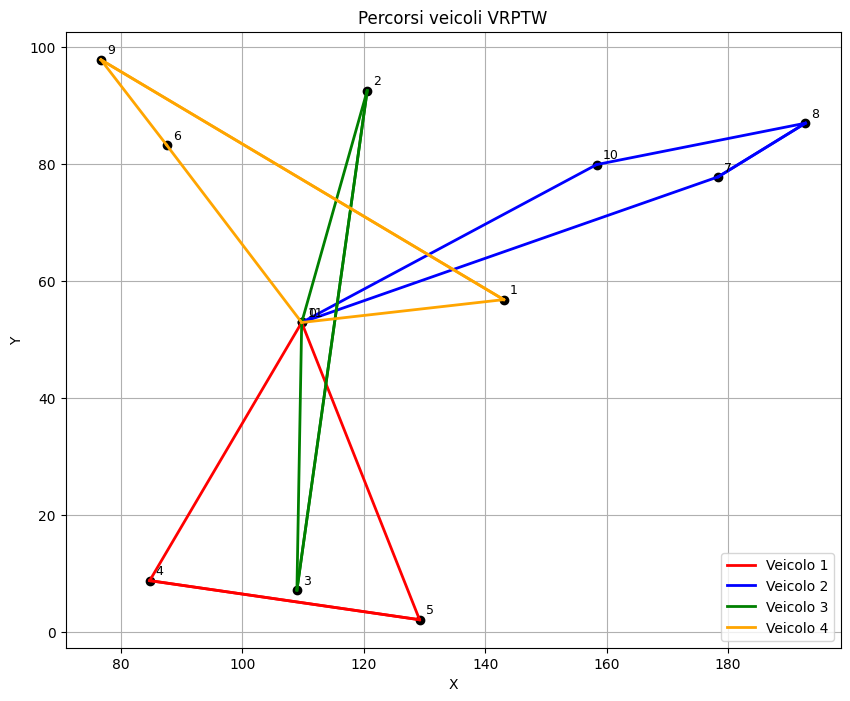

In [23]:
# Colori per i veicoli
colori = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

plt.figure(figsize=(10, 8))

# Disegna i nodi
for i in N:
  plt.plot(xc[i], yc[i], 'ko')
  plt.text(xc[i]+1, yc[i]+1, str(i), fontsize=9)

for k, liste_rotte in rotte_per_veicolo.items():
    for rot in liste_rotte:
        for nodo in range(len(rot)):
            if nodo==0:
                plt.plot([xc[0], xc[rot[nodo]]], [yc[0], yc[rot[nodo]]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')
                plt.plot([xc[rot[nodo]], xc[rot[nodo+1]]], [yc[rot[nodo]], yc[rot[nodo+1]]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')
            if nodo==len(rot)-1:
                plt.plot([xc[rot[nodo]], xc[n+1]], [yc[rot[nodo]], yc[n+1]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')
            else:
                plt.plot([xc[rot[nodo]], xc[rot[nodo+1]]], [yc[rot[nodo]], yc[rot[nodo+1]]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')

# Evita duplicati nella legenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Percorsi veicoli VRPTW")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()
           